### I. Import Libraries

In [1]:
import time
import pickle
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)

### II. Import and Examine Dataset

In [2]:
ner_data = 'Datasets/ner_dataset.txt'
df = pd.read_csv(ner_data, sep=' ', header=None)
df.columns = ['token', 'pos_tag', 'chunk_tag', 'ne_tag']
df.head()

,token,pos_tag,chunk_tag,ne_tag
0,-DOCSTART-,-X-,-X-,O
1,EU,NNP,B-NP,B-ORG
2,rejects,VBZ,B-VP,O
3,German,JJ,B-NP,B-MISC
4,call,NN,I-NP,O


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256145 entries, 0 to 256144
Data columns (total 4 columns):
token        256139 non-null object
pos_tag      256145 non-null object
chunk_tag    256145 non-null object
ne_tag       253327 non-null object
dtypes: object(4)
memory usage: 7.8+ MB


Remove the rows with missing values: 6 are missing tokens, and 2,818 are missing named entity tags. These are presumably the empty lines after every sentence.

In [4]:
null_columns = df.columns[df.isnull().any()]
print(df[null_columns].isnull().sum())

df[df.isnull().any(axis=1)][null_columns].head()

token        6
ne_tag    2818
dtype: int64


,token,ne_tag
75,,NaN
93,,NaN
260,,NaN
264,,NaN
366,,NaN


In [5]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True) # Reset the index so that it reflects the length of the dataframe and its columns. 
df.info() # Confirm that the missing values have been dropped.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253321 entries, 0 to 253320
Data columns (total 4 columns):
token        253321 non-null object
pos_tag      253321 non-null object
chunk_tag    253321 non-null object
ne_tag       253321 non-null object
dtypes: object(4)
memory usage: 7.7+ MB


In [6]:
df.pos_tag.value_counts()

NNP       42946
NN        29923
IN        24041
CD        24000
DT        16974
JJ        14874
NNS       12406
VBD       10523
.          9268
,          9240
VB         5371
VBN        5098
RB         4964
CC         4585
TO         4375
PRP        4025
)          3546
(          3545
VBG        3285
:          3010
VBZ        2937
POS        1976
PRP$       1942
VBP        1801
MD         1499
-X-        1162
NNPS        850
RP          678
WDT         661
WP          655
$           528
SYM         525
JJR         487
WRB         477
JJS         332
RBR         216
FW          195
EX          176
RBS          53
''           46
PDT          40
UH           35
WP$          32
LS           14
NN|SYM        5
Name: pos_tag, dtype: int64

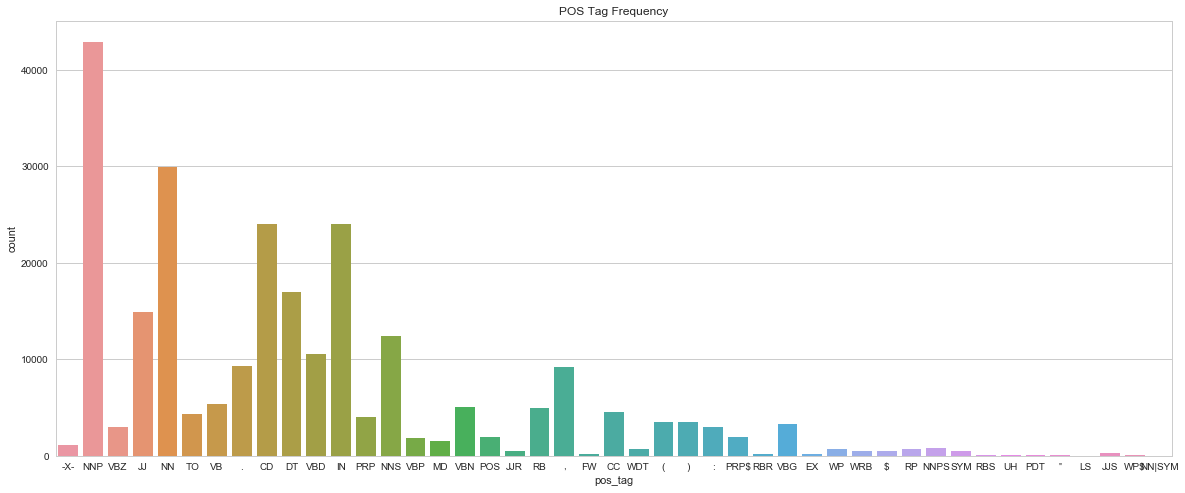

In [67]:
fig = plt.figure(figsize=(20,8))
plt.title('POS Tag Frequency')
sns.countplot(data=df, x='pos_tag');

In [68]:
df.chunk_tag.value_counts()

I-NP       82998
B-NP       72025
O          31800
B-PP       23727
B-VP       22743
I-VP       10989
B-ADVP      3287
B-SBAR      1635
B-ADJP      1471
-X-         1162
B-PRT        674
I-ADJP       263
I-ADVP       177
I-PP         120
B-INTJ        90
I-CONJP       52
B-CONJP       41
B-LST         35
I-SBAR        25
I-LST          4
I-PRT          2
I-INTJ         1
Name: chunk_tag, dtype: int64

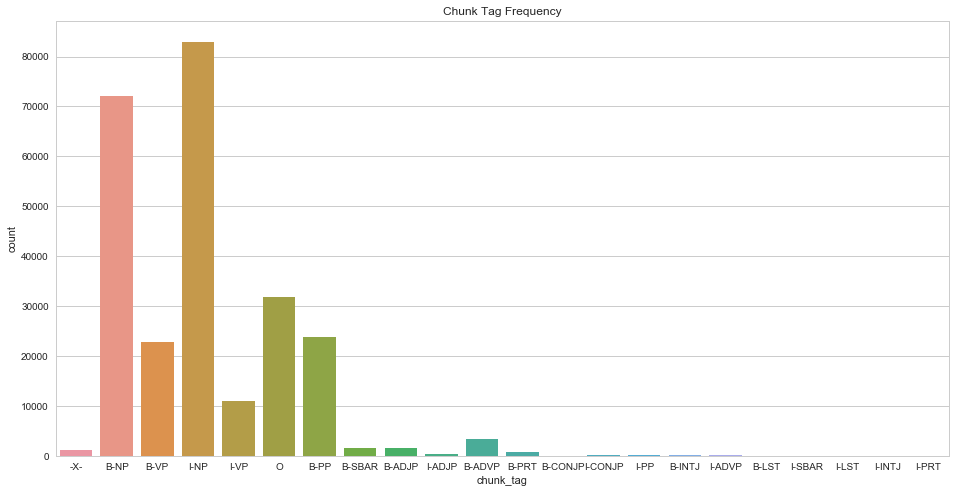

In [69]:
fig = plt.figure(figsize=(16,8))
plt.title('Chunk Tag Frequency')
sns.countplot(data=df, x='chunk_tag');

The vast majority of tokens are not named entities: 210,679 out of 253,321 (83.17%). This is one baseline for classifier accuracy.

In [70]:
df.ne_tag.value_counts()

O         210679
B-LOC       8977
B-PER       8442
B-ORG       7662
I-PER       5831
I-ORG       4455
B-MISC      4360
I-MISC      1501
I-LOC       1414
Name: ne_tag, dtype: int64

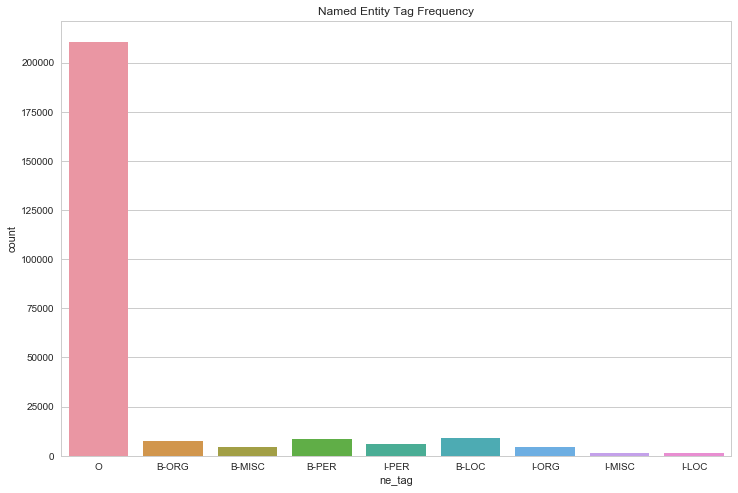

In [71]:
fig = plt.figure(figsize=(12,8))
plt.title('Named Entity Tag Frequency')
sns.countplot(data=df, x='ne_tag');

To better understand the tags for feature engineering (what are the qualities/patterns that certain tags have?), generate examples of each.

General named entity feature trends: capitalisation; POS tag is noun of some kind.

In [72]:
#df[df.ne_tag=='B-ORG'].sample(20) # First word in organisation name. Some tokens are abbreviations in all caps (e.g., 'EU').
#df[df.ne_tag=='I-ORG'].sample(20) # Second word in organisation name.
#df[df.ne_tag=='B-MISC'].sample(20) # Not sure how this differs from B-ORG. Many are adjectives.
#df[df.ne_tag=='I-MISC'].sample(20) # Second part of B-MISC.
df[df.ne_tag=='B-PER'].sample(20) # First names of people.
#df[df.ne_tag=='I-PER'].sample(20) # Surnames of people. Mostly capitalised but not always (e.g., 'van').
#df[df.ne_tag=='B-LOC'].sample(20) # Country and city names.
#df[df.ne_tag=='I-LOC'].sample(20) # Second part of country and city names.

,token,pos_tag,chunk_tag,ne_tag
58122,Sam,NNP,B-NP,B-PER
174215,Mullally,NNP,B-NP,B-PER
138216,Shane,NNP,B-NP,B-PER
152658,Remmy,NNP,I-NP,B-PER
118294,Jack,NNP,B-NP,B-PER
64583,Olofsson,NNP,I-NP,B-PER
32450,Dennis,NNP,I-NP,B-PER
209174,D.,NNP,B-NP,B-PER
67252,Mullally,RB,B-NP,B-PER
246170,Fulgencio,NNP,B-NP,B-PER


### III. Feature Engineering and Prepare Training and Validation Sets

In [7]:
def features(token, index, pos_tag, ne_tag):
    first_letter = token[index][0]
    features = {'token': token[index],
                'pos': pos_tag[index],
#                'chunk': chunk_tag[index],
                'prev_token': '' if index == 0 else token[index-1],
                'prev_pos': '' if index == 0 else pos_tag[index-1],
                'prev_ne': '' if index == 0 else ne_tag[index-1],
                'next_token': '' if index == len(df.token)-1 else token[index+1],
                'next_pos': '' if index == len(df.token)-1 else pos_tag[index+1],
                'prev_prev_token': '' if index == 0 or index == 1 else token[index-2],
                'prev_prev_pos': '' if index == 0 or index == 1 else pos_tag[index-2],
                'next_next_token': '' if index == len(df.token)-1 or index == len(df.token)-2 else token[index+2],
                'next_next_pos': '' if index == len(df.token)-1 or index == len(df.token)-2 else pos_tag[index+2],
                'is_capitalized': first_letter.upper() in string.ascii_uppercase and first_letter.upper() == first_letter,
                'is_numeric': token[index].isdigit(),                
                'is_all_caps': token[index].upper() == token[index],
                'caps_inside': token[index][1:].lower() != token[index][1:]
                }
    return features
    
X = []

for index in range(len(df.token)):
    X.append(features(df.token, index, df.pos_tag, df.ne_tag))

In [8]:
X[:5]

[{'caps_inside': True,
  'is_all_caps': True,
  'is_capitalized': False,
  'is_numeric': False,
  'next_next_pos': 'VBZ',
  'next_next_token': 'rejects',
  'next_pos': 'NNP',
  'next_token': 'EU',
  'pos': '-X-',
  'prev_ne': '',
  'prev_pos': '',
  'prev_prev_pos': '',
  'prev_prev_token': '',
  'prev_token': '',
  'token': '-DOCSTART-'},
 {'caps_inside': True,
  'is_all_caps': True,
  'is_capitalized': True,
  'is_numeric': False,
  'next_next_pos': 'JJ',
  'next_next_token': 'German',
  'next_pos': 'VBZ',
  'next_token': 'rejects',
  'pos': 'NNP',
  'prev_ne': 'O',
  'prev_pos': '-X-',
  'prev_prev_pos': '',
  'prev_prev_token': '',
  'prev_token': '-DOCSTART-',
  'token': 'EU'},
 {'caps_inside': False,
  'is_all_caps': False,
  'is_capitalized': False,
  'is_numeric': False,
  'next_next_pos': 'NN',
  'next_next_token': 'call',
  'next_pos': 'JJ',
  'next_token': 'German',
  'pos': 'VBZ',
  'prev_ne': 'B-ORG',
  'prev_pos': 'NNP',
  'prev_prev_pos': '-X-',
  'prev_prev_token': '-DO

In [9]:
y = df['ne_tag']

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.1, random_state=0)

print("Size of training set (POS tags):", len(X_train)) 
print("Size of test set (POS tags):", len(X_test)) 
print("Size of training set (chunk tags):", len(y_train)) 
print("Size of test set (chunk tags):", len(y_test)) 

Size of training set (POS tags): 227988
Size of test set (POS tags): 25333
Size of training set (chunk tags): 227988
Size of test set (chunk tags): 25333


### IV. Classifier Training

In [162]:
# token, pos: 0.8932555327159474
# token, chunk: 0.8494862890783083 (took a LOT longer)
# token, pos, chunk: 0.8957114704338746 (chunk doesn't help)
# token, pos, previous token/pos: 0.8995017958096173
# token, pos, previous token/pos, next token/pos: 0.9055109354730966
# token, pos, previous token/pos, next token/pos, is_capitalised: 0.9115229634875965
# token, pos, previous token/pos, previous previous token/pos, next token/pos, next next token/pos, is_capitalised: 0.9128023148431639
# '', is_numeric: 0.9127205040729689
# '', is_all_caps: 0.9132049059426229
# '', caps_inside: 0.9142095785522023
# ', prev_ne: 0.9387959473000405

start_time = time.time()

clf_dt = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', DecisionTreeClassifier(random_state=0, criterion='entropy'))])
 
clf_dt.fit(X_train[:10000], y_train[:10000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_dt = clf_dt.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_dt, average='weighted'))

Total time: 15.670546293258667
Mean F1 score (weighted): 0.9387959473000405


In [168]:
start_time = time.time()

clf_nb = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', MultinomialNB(alpha=0.01))])
 
clf_nb.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_nb = clf_nb.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_nb, average='weighted'))

Total time: 172.65969443321228
Mean F1 score (weighted): 0.9533148711103568


In [167]:
start_time = time.time()

clf_lr = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', LogisticRegression(random_state=0, class_weight='balanced', solver='liblinear'))])
 
clf_lr.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_lr = clf_lr.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_lr, average='weighted'))

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Total time: 130.3456950187683
Mean F1 score (weighted): 0.9636838347388728


In [10]:
start_time = time.time()

clf_svc = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                    ('classifier', LinearSVC(random_state=0, class_weight='balanced', max_iter=10000))])
 
clf_svc.fit(X_train[:50000], y_train[:50000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_svc = clf_svc.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_svc, average='weighted'))

Total time: 103.70104312896729
Mean F1 score (weighted): 0.9740423764118118


In [11]:
print(metrics.classification_report(y_test, predicted_svc))

              precision    recall  f1-score   support

       B-LOC       0.87      0.91      0.89       901
      B-MISC       0.82      0.81      0.82       434
       B-ORG       0.82      0.77      0.79       783
       B-PER       0.86      0.90      0.88       856
       I-LOC       0.85      0.96      0.90       157
      I-MISC       0.80      0.95      0.87       148
       I-ORG       0.95      0.96      0.95       452
       I-PER       0.98      1.00      0.99       551
           O       1.00      0.99      0.99     21051

   micro avg       0.97      0.97      0.97     25333
   macro avg       0.88      0.92      0.90     25333
weighted avg       0.97      0.97      0.97     25333



In [12]:
save_classifier = open('ne_clf_svc.pickle', 'wb') 
pickle.dump(clf_svc, save_classifier)
save_classifier.close()